In [1]:
# Import necessary libraries
import numpy as np
from scipy.linalg import expm
from scipy.stats import norm
import matplotlib.pyplot as plt


## Open system model formulation with 5 free parameters

In Busemeyer et al. (2020) and Kvam et al. (2021), the open system model is defined as
$$
\frac{d}{dt} \rho(t) = -i \big(1 - w\big) \big[H(v_Q, \sigma_Q), \rho(t)\big] + w\sum_{ij} \gamma_{ij}(v_M, \sigma_M) \Big(L_{ij} \rho(t) L_{ij}^{\dagger} - 0.5 \left\{L_{ij}^{\dagger} L_{ij}, \rho(t) \right\}  \Big)
$$
where there free parameters are:
1. $w$ (weighting parameter)
2. $v_Q$ (drift rate parameter in the quantum component)
3. $\sigma_Q$ (diffusion rate parameter in the quantum component)
4. $v_M$ (drift rate parameter in the Markov component)
5. $\sigma_M$ (diffusion rate parameter)

The pair of parameters $(v_Q, \sigma_Q)$ are used to define the Hamiltonian matrix as
$$
H(v_Q, \sigma_Q) = 
\begin{bmatrix}
\mu_1 & \sigma_Q & 0 & \ldots & 0 \\
\sigma_Q & \mu_2 & \ddots & \ddots & \vdots \\
0 & \sigma_Q & \ddots & \sigma_Q & 0 \\
\vdots & \ddots & \ddots & \mu_{N-1} & \sigma_Q \\
0 & \cdots & 0 & \sigma_Q & \mu_{N}
\end{bmatrix}
\qquad
\begin{align}
\mu_j & = j \cdot v_Q \\
N & \equiv \text{number of basis states}
\end{align}
$$

The pair of parameters $(v_M, \sigma_M)$ are used to define the Generator matrix as
$$
G(v_M, \sigma_M) = 
\begin{bmatrix}
-\beta & \alpha & 0 & \ldots & 0 \\
\beta & -\lambda & \ddots & \ddots & \vdots \\
0 & \beta & \ddots & \alpha & 0 \\
\vdots & \ddots & \ddots & -\lambda & \alpha \\
0 & \cdots & 0 & \beta & -\alpha
\end{bmatrix}
\qquad
\begin{align}
\alpha & = \sigma_M - v_M \\
\beta & = \sigma_M + v_M \\
\lambda & = -2\sigma_M
\end{align}
$$

In the model, ***$\gamma_{ij}(v_M, \sigma_M)$ is defined as the element located in row $i$, column $j$ of the Generator matrix $G(v_M, \sigma_M)$***. For example, $\gamma_{21}(v_M, \sigma_M) = \beta$. 

$L_{ij}$ is simply a matrix of 0's, except for a 1 at the element located in row $i$, column $j$.

Lastly, $\rho(t)$ is the state of the system.

## Open system model formulation with 4 parameters

While working with the open system model, I noticed that only 4 parameters are needed to define the model without loss of generality. The model itself looks very similar

$$
\frac{d}{dt} \rho(t) = \delta \bigg( -i \big(1 - \omega \big) \big[H(\eta_Q, 1), \rho(t)\big] + \omega \sum_{ij} \gamma_{ij}(\eta_M, 1) \bigg(L_{ij} \rho(t) L_{ij}^{\dagger} - 0.5 \left\{L_{ij}^{\dagger} L_{ij}, \rho(t) \right\}  \Big) \bigg)
$$

where there free parameters are:
1. $\omega$ (weighting parameter)
2. $\eta_Q$ (drift rate to diffusion rate ratio parameter in the quantum component)
3. $\eta_M$ (drift rate to diffusion rate ratio parameter in the Markov component)
4. $\delta$ (scaling parameter)

I won't go through all the math, but in terms of the parameters from the 5-parameter model, these 4 free parameters can be defined as
1. $\omega = \frac{w \cdot \sigma_M}{(1-w) \cdot \sigma_Q + w \cdot \sigma_M}$
2. $\eta_Q= \frac{v_Q}{\sigma_Q}$
3. $\eta_Q= \frac{v_M}{\sigma_M}$
4. $\delta = (1-w) \cdot \sigma_Q + w \cdot \sigma_M$

# Running the model

For a few parameter values, I think it'd be best to go with the ones from Busemeyer et al. (2020) (https://www.mdpi.com/1099-4300/22/9/990). These values are for the 5-parameter model because the authors didn't realize that they only needed the 4 at the time. Those parameter values are:
1. $w = 0.5$
2. $v_Q = 37.4$
3. $\sigma_Q = 54.98$
4. $v_M = 25$
5. $\sigma_M = 175$

In the code below, I convert them over to the 4 parameters before simulating the model. 

In [2]:
# Parameters from Busemeyer et al. (2020) 

# Model parameters
wgt_param = 0.5 # weighting parameter
driftQ = 37.4 # drift rate for the quantum component
diffusionQ = 54.98 # diffusion rate for the quantum component
driftM = 25 # drift rate for the Markov component
diffusionM = 175 # diffusion rate for the Markov component

# Simulation parameters 
num_states = 21 # number of basis states for the random walk
init_std = 5 # standard deviation of the initial state
num_time_pts = 101 # number of time points
min_time_pt = 0 # starting time point
max_time_pt = 5 # final time point
time_pts = np.linspace(min_time_pt, max_time_pt, num_time_pts)# actual time points

In [3]:
# Define the model parameters for the 4-parameter version of the model in terms 
# of the parameters from the the 5-parameter version of the model
etaQ = driftQ/diffusionQ # slope to diffusion rate ratio in quantum component
etaM = driftM/diffusionM # drift rate to diffusion rate ratio in Markov component
delta = (1-wgt_param)*diffusionQ + wgt_param*diffusionM # scaling parameter
omega = wgt_param*diffusionM/delta # weighting parameter


In [4]:
# Function to create the Hamiltonian
def H_mat(slope, diffusion, num_states):
    
    # Elements on the diagonal
    H_diag = slope*(np.arange(num_states)+1)
    
    # Elements on the off-diagonals (both upper and lower)
    H_off_diag = diffusion*np.ones(num_states-1)
    
    # Combine them to create the full matrix
    H = np.diag(H_diag) + np.diag(H_off_diag, 1) + np.diag(H_off_diag, -1)
    return H


# Function to create the Generator matrix
def G_mat(drift, diffusion, num_states):
    
    # Convert drift and diffusion to alpha and beta values 
    alpha = diffusion - drift
    beta = diffusion + drift
    
    # Elements on the diagonal
    G_diag = -2*diffusion*np.ones(num_states)
    
    # Element on the upper-diagonal
    G_upper_diag = alpha*np.ones(num_states-1)
    
    # Elements on the lower-diagonal
    G_lower_diag = beta*np.ones(num_states-1)
    
    # Combine them to create the full matrix
    G = np.diag(G_diag) + np.diag(G_upper_diag, 1) + np.diag(G_lower_diag, -1)
    
    # Redefine the two 'corner' elements since the columns of the Generator must sum to 0
    G[0, 0] = -1*beta
    G[num_states-1, num_states-1] = -1*alpha
    return G

### Note

When simulating the model, I need to vectorize the state of the system (the density matrix $\rho$) and modify the open system model formulation such that it takes the form of a linear differential equation. 

I believe I needed to do this because, when I run the open system model, I am operating on probabilities. Meaning, the state of the system is just a bunch of probabilities. I don't think you'll need to do this when actually implementing the model with an actual quantum system, but I at least wanted to make a note of this in case you notice that some of the code below doesn't line-up with the open system model as described above. If you would like to learn more about how and why this is done in my case, see https://www.mdpi.com/1099-4300/22/9/990.

In [5]:
# Function to create the Lindbladian operator
def L_mat(t, omega, delta, H, G, num_states):
    # Initialize an identity matrix
    idn = np.eye(num_states)
    
    # Define the quantum component
    Q_comp = np.kron(idn,H) - np.kron(H,idn)
    
    # Define the Markov component
    M_comp = np.zeros((num_states**2, num_states**2))
       
    for i in range(num_states):
        for k in range(num_states):
            # Define gamma using the Generator matrix
            gamma = G[i,k]
            
            # Create the Lindblad operator for this pair of indices
            ik_mat = np.zeros((num_states, num_states))
            ik_mat[i,k] = 1
            ik_trans = np.transpose(ik_mat)
            
            # Compute the anticommutator
            anti_comm = np.kron(idn, np.matmul(ik_trans,ik_mat)) + np.kron(np.matmul(ik_trans,ik_mat), idn)
            
            # Update the Markov component
            M_comp += gamma*(np.kron(ik_mat, ik_mat) - 0.5*anti_comm)
    
    # Combine the two components with the weighting parameter 
    wgtd_mat = -1j*(1-omega)*Q_comp + omega*M_comp
    
    # Multiply the matrix by the scaling parameter delta and t, then exponentiate
    L = expm(t*delta*wgtd_mat)
    return L            

In [6]:
# Function to make the initial state
def init_state(num_states, init_std):
    # Create the initial state vector as a Gaussian distribution centered on the basis states
    basis_states = np.arange(num_states)
    init_state_vec = np.exp(-1*np.power((basis_states-np.mean(basis_states))/init_std, 2))
    
    # Normalize it such that the squared magnitude of the elements sums to 1
    norm_state_vec = init_state_vec/np.sqrt(np.inner(init_state_vec, init_state_vec))
    
    # Create the density matrix by taking the outer product of the normalized state vector
    rho = np.outer(norm_state_vec, norm_state_vec)
    return rho

In [7]:
# Run the simulation

# Define the initial state as a density matrix
rho = init_state(num_states, init_std)

# Vectorize the density matrix for computation
rho_vec = rho.reshape(-1,1)

# Create the Hamiltonian and Generator matrices
H = H_mat(etaQ, 1, num_states)
G = G_mat(etaM, 1, num_states)

# Initialize a matrix to store the probabilities at each time point
prob_dens = np.zeros((num_states, num_time_pts))

# Run through each step in the random walk
for idx, tt in enumerate(time_pts):
    # Create the Lindbladian operator to update the state
    L = L_mat(tt, omega, delta, H, G, num_states)
    
    # Apply the Lindbladian to map the state from t=0 to t=tt
    rhot = L.dot(rho_vec)
    
    # Reshape the state back into the density matrix form
    rhot_mat = rhot.reshape(num_states, num_states)
    
    # Extract the diagonal elements from the updated state, 
    # which correspond to the probabilities of the system 
    # being observed in each basis state, and store them
    prob_dens[:,idx] = np.diag(rhot_mat)

/var/folders/p3/gy95rxqn14gdk9cx0v_db7gw0000gq/T/ipykernel_89093/1715397729.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  prob_dens[:,idx] = np.diag(rhot_mat)


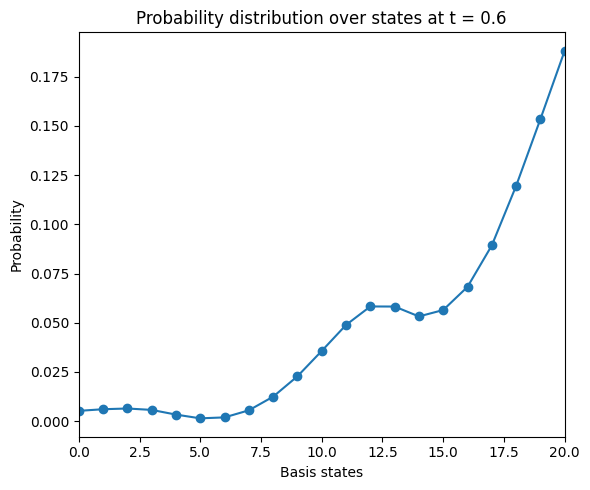

In [8]:
# Have a look at the probability distribution at some arbitrary time point
arbitrary_time_index = 12

fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.plot(prob_dens[:,arbitrary_time_index], '-o')
ax.set_xlim(0, num_states-1)

ax.set_xlabel('Basis states')
ax.set_ylabel('Probability')
ax.set_title(f'Probability distribution over states at t = {round(time_pts[arbitrary_time_index],3)}')

fig.tight_layout()
plt.show()

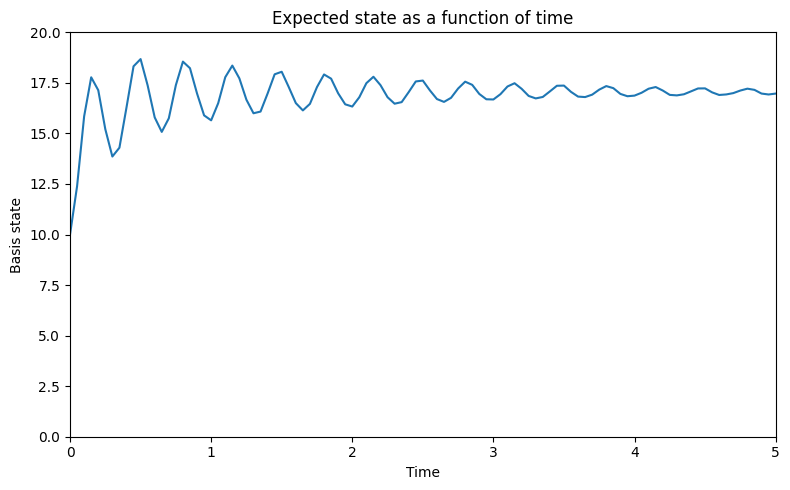

In [9]:
# Plot the expected value of the probability distribution as a function of time
basis_states = np.arange(num_states)
prob_exp = [np.inner(basis_states, prob_dens[:,i]) for i in range(num_time_pts)]

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(time_pts,prob_exp)
ax.set_xlim(min_time_pt, max_time_pt)
ax.set_ylim(0, num_states-1)

ax.set_xlabel('Time')
ax.set_ylabel('Basis state')
ax.set_title('Expected state as a function of time')

fig.tight_layout()

plt.show()